In [ ]:
!python --version

Python 3.10.12


# Sezione Anomaly Detection on KDDCUP99


## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/RetiGeografiche-Progetto/AnomalyDetectionSystem/

/content/drive/MyDrive/RetiGeografiche-Progetto/AnomalyDetectionSystem


In [3]:
ls

 average_anomaly_detection_results-10-2.txt      hyperband/
 average_anomaly_detection_results-10.txt        KDDCUP99/
 datasets/                                       models/
 esperimento1_anomaly_detection_results-10.txt   requirements.txt
 esperimento2_anomaly_detection_results-10.txt  'RG - Anomaly Detection System.ipynb'
 esperimento3_anomaly_detection_results-10.txt


In [ ]:
!sudo pip uninstall keras
!sudo pip uninstall tensorflow

!sudo pip install tensorflow
!sudo pip install keras

In [ ]:
!pip install keras --upgrade

In [ ]:
!pip freeze > requirements.txt

In [4]:
import random
import numpy as np
import keras
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt

Funzioni di utilità
- getClassification: Questa funzione cerca colonne contenenti 'classification' o 'Classification' nel DataFrame df. Restituisce il nome della prima colonna trovata. Se nessuna colonna è trovata, restituisce una lista vuota.

- getXY: Questa funzione prende un DataFrame train e il prefisso della colonna di classificazione clsTrain. Estrae la colonna di destinazione (etichetta) dal DataFrame come train_Y e rimuove questa colonna dal DataFrame per creare il dataset train_X. Restituisce train_X e train_Y.

- getXY_mod: Questa funzione è simile a getXY, ma aggiunge la funzionalità di suddividere il dataset in set di addestramento e test utilizzando train_test_split dalla libreria scikit-learn. Restituisce sia i set di addestramento che il test per X e Y. test_size, che rappresenta la frazione del dataset da includere nel set di test, può essere specificato come argomento opzionale.

In [5]:
def getClassification(df):
    _cls = list()
    # Trova colonne contenenti 'classification' o 'Classification'
    _cls.append([col for col in df.columns if 'classification' in col])
    _cls.append([col for col in df.columns if 'Classification' in col])
    _cls.append([])

    print(_cls)

    # Seleziona l'elenco corretto tra 'classification' e 'Classification'
    _cls = _cls[0] if _cls[0] else _cls[1]

    print(_cls)
    return _cls[0]

def getXY(train, clsTrain):
    clssList = train.columns.values
    # Seleziona la colonna di destinazione in base al prefisso fornito
    target = [i for i in clssList if i.startswith(clsTrain)][0]

    # Rimuovi l'etichetta dal dataset per creare il dataset Y
    train_Y = train[target]
    train_X = train.drop(target, axis=1)
    train_X = train_X.values
    return train_X, train_Y

from sklearn.model_selection import train_test_split

def getXY_mod(train, clsTrain, test_size=0.2, random_state=42):
    clssList = train.columns.values
    # Seleziona la colonna di destinazione in base al prefisso fornito
    target = [i for i in clssList if i.startswith(clsTrain)][0]

    # Rimuovi l'etichetta dal dataset per creare il dataset Y
    train_Y = train[target]
    train_X = train.drop(target, axis=1)
    train_X = train_X.values

    # Suddividi il dataset in set di addestramento e test
    train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=test_size, random_state=random_state)

    return train_X, test_X, train_Y, test_Y


# Carica dataset generale
- Train - Classe 1 (Normal), Classe 0 (Anormal)
- Test

In [6]:
import pandas as pd
from sklearn.utils import shuffle

# Percorso del dataset numerico
pathDatasetNumeric = "./datasets/KDDCUP99/numeric/"

# Carica i dataset di addestramento e test
train = pd.read_csv(pathDatasetNumeric + 'Train_standard.csv')
test = pd.read_csv(pathDatasetNumeric + 'Test.csv')

# Ottieni il nome della colonna di classificazione dal dataset di addestramento
_clsTrain = getClassification(train)

# Estrai le istanze normali e anomale dal dataset di addestramento
train_normal = train[(train[_clsTrain] == 1)]
print("train normal:", train_normal.shape)
train_anormal = train[(train[_clsTrain] == 0)]
print("train anormal:", train_anormal.shape)

# Estrai le features e le etichette per le istanze normali e anomale
train_X_anormal, train_Y_anormal = getXY(train_anormal, _clsTrain)
train_X_normal, train_Y_normal = getXY(train_normal, _clsTrain)
print("\nShapes and lengths after extraction:")
print("Train X Anormal:", train_X_anormal.shape)
print("Train Y Anormal:", train_Y_anormal.shape)
print("Train X Normal:", train_X_normal.shape)
print("Train Y Normal :", train_Y_normal.shape)

# Assume che ci sia una funzione getXY per estrarre features (test_X) e etichette (test_Y)
_clsTest = getClassification(test)
test_X, test_Y = getXY(test, _clsTest)

# Stampa informazioni sul set di test dopo l'estrazione
print("\nShapes and lengths after extraction:")
print("Test X Length:", len(test_X))
print("Test Y Length:", len(test_Y))

# Mescola i dati di test mantenendo la corrispondenza tra features e etichette
test_X, test_Y = shuffle(test_X, test_Y, random_state=42)


[[' classification.'], [], []]
[' classification.']
train normal: (97278, 120)
train anormal: (396743, 120)

Shapes and lengths after extraction:
Train X Anormal: (396743, 119)
Train Y Anormal: (396743,)
Train X Normal: (97278, 119)
Train Y Normal : (97278,)
[[' classification.'], [], []]
[' classification.']

Shapes and lengths after extraction:
Test X Length: 311029
Test Y Length: 311029


# Sezione Autoencoder

## Tuning iperparametri

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model, callbacks
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.utils import shuffle
import pandas as pd
import kerastuner as kt

class GlobalConfig:
    best_score = float('inf')
    best_model = None
    best_numparameters = 0
    best_time = 0

global_config = GlobalConfig()

def train_autoencoder(train_X, train_Y, test_X, test_Y, is_anormal=True):
    print(f"Training Autoencoder for {'Anormal' if is_anormal else 'Normal'} Data...")

    input_shape = (train_X.shape[1],)
    input2 = Input(input_shape)

    encoded = Dense(32, activation='relu', kernel_initializer='glorot_uniform', name='encod1')(input2)
    encoded = Dense(16, activation='relu', kernel_initializer='glorot_uniform', name='encod2')(encoded)
    encoded = Dropout(0.5)(encoded)

    decoded = Dense(32, activation='relu', kernel_initializer='glorot_uniform', name='decoder1')(encoded)
    decoded = Dense(train_X.shape[1], activation='linear', kernel_initializer='glorot_uniform', name='decoder3')(decoded)

    model = Model(inputs=input2, outputs=decoded)
    model.summary()

    adam = Adam(lr=0.001)
    model.compile(loss='mse', metrics=['acc'], optimizer=adam)

    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True),
    ]

    XTraining, XValidation, YTraining, YValidation = train_test_split(train_X, train_Y, stratify=train_Y, test_size=0.2)

    tic = time.time()

    def build_model(hp):
        encoded = Dense(units=hp.Int('units1', min_value=16, max_value=64, step=16),
                        activation='relu',
                        kernel_initializer='glorot_uniform',
                        name='encod1')(input2)
        encoded = Dense(units=hp.Int('units2', min_value=8, max_value=32, step=8),
                        activation='relu',
                        kernel_initializer='glorot_uniform',
                        name='encod2')(encoded)
        encoded = Dropout(hp.Float('dropout', min_value=0.1, max_value=1, step=0.1))(encoded)
        decoded = Dense(units=hp.Int('units3', min_value=16, max_value=64, step=16),
                        activation='relu',
                        kernel_initializer='glorot_uniform',
                        name='decoder1')(encoded)
        decoded = Dense(units=train_X.shape[1], activation='linear',
                        kernel_initializer='glorot_uniform',
                        name='decoder3')(decoded)

        model = Model(inputs=input2, outputs=decoded)

        adam = Adam(lr=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log'))
        model.compile(loss='mse', metrics=['acc'], optimizer=adam)
        return model

    # Crea un oggetto HyperParameters
    hp = HyperParameters()

    # Aggiungi iperparametri al tuo oggetto hp
    hp.Int('batch_size', min_value=32, max_value=512, step=32)
    tuner = kt.Hyperband(
        build_model,
        hyperparameters=hp,
        objective='val_loss',
        max_epochs=20,  # Numero massimo di epoche per configurazione
        factor=3,  # Fattore di riduzione del numero di configurazioni
        directory=f'tuning_autoencoder1/{"not_" if not is_anormal else ""}anormal',
        project_name=f'autoencoder{"not_" if not is_anormal else ""}anormal'
    )

    tuner.search(
        XTraining, XTraining,
        epochs=20,
        verbose=1,
        callbacks=callbacks_list,
        validation_data=(XValidation, XValidation)
    )

    toc = time.time()

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.oracle.get_best_trials(1)[0].hyperparameters.values

    # Fit the model and store the training history
    history = best_model.fit(train_X, train_X, epochs=100, batch_size=best_hp['batch_size'],
                             validation_split=0.2, verbose=1, callbacks=callbacks_list)

    test_loss = best_model.evaluate(test_X, test_X)

    print("\nBest Model Summary:")
    print("Best Model Architecture:")
    best_model.summary()

    model_name = f"autoencoder_{'anormal1' if is_anormal else 'normal1'}"
    best_model.save(f"{model_name}.h5")

    return {'loss': test_loss[0],
            'status': 'ok',
            'n_params': best_model.count_params(),
            'model': best_model,
            'time': toc - tic,
            'model_name': model_name,
            'history': history.history}

# Train Autoencoder for Anormal Data
result_anormal = train_autoencoder(train_X_anormal, train_Y_anormal, test_X, test_Y, is_anormal=True)

print(result_anormal)

# Train Autoencoder for Normal Data
result_normal = train_autoencoder(train_X_normal, train_Y_normal, test_X, test_Y, is_anormal=False)
print(result_normal)


Trial 30 Complete [00h 02m 32s]
val_loss: 0.00024476833641529083

Best val_loss So Far: 0.0001962739770533517
Total elapsed time: 00h 29m 55s


Epoch 1/100
188/188 [==============================] - 3s 11ms/step - loss: 2.8170e-04 - acc: 0.1509 - val_loss: 2.5597e-04 - val_acc: 0.1177
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 2.7420e-04 - acc: 0.1496 - val_loss: 2.5431e-04 - val_acc: 0.0966
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6632e-04 - acc: 0.1375 - val_loss: 2.6716e-04 - val_acc: 0.2676
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6395e-04 - acc: 0.1489 - val_loss: 2.6537e-04 - val_acc: 0.1370
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6605e-04 - acc: 0.1537 - val_loss: 2.6770e-04 - val_acc: 0.1375
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6188e-04 - acc: 0.1464 - val_loss: 2.5669e-04 - val_acc: 0.0974
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6038e-04 - acc: 0.1521 - val_loss: 2.7097e-04 - val_acc: 0.1938
Epoch 8/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Validazione modello - Grafici

Training Autoencoder for Anormal Data...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 119)]             0         
                                                                 
 encod1 (Dense)              (None, 32)                3840      
                                                                 
 encod2 (Dense)              (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 decoder1 (Dense)            (None, 32)                544       
                                                                 
 decoder3 (Dense)            (None, 119)               3927      
                                                                 
Total params: 8839

Reloading Tuner from tuning_autoencoder1/anormal/autoencoderanormal/tuner0.json


Epoch 1/100
620/620 [==============================] - 5s 7ms/step - loss: 1.7602e-04 - acc: 0.0861 - val_loss: 2.3885e-04 - val_acc: 0.0036
Epoch 2/100
620/620 [==============================] - 8s 13ms/step - loss: 1.7330e-04 - acc: 0.0826 - val_loss: 3.3139e-04 - val_acc: 0.0023
Epoch 3/100
620/620 [==============================] - 10s 16ms/step - loss: 1.7136e-04 - acc: 0.0837 - val_loss: 4.2025e-04 - val_acc: 0.0040
Epoch 4/100
620/620 [==============================] - 8s 12ms/step - loss: 1.7119e-04 - acc: 0.0843 - val_loss: 5.7339e-04 - val_acc: 0.0028
Epoch 5/100
620/620 [==============================] - 10s 15ms/step - loss: 1.6953e-04 - acc: 0.0782 - val_loss: 6.7768e-04 - val_acc: 0.0014
Epoch 6/100
620/620 [==============================] - 8s 12ms/step - loss: 1.6879e-04 - acc: 0.0755 - val_loss: 7.4020e-04 - val_acc: 0.0044
Epoch 7/100
620/620 [==============================] - 10s 16ms/step - loss: 1.6922e-04 - acc: 0.0855 - val_loss: 8.9282e-04 - val_acc: 0.0029
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


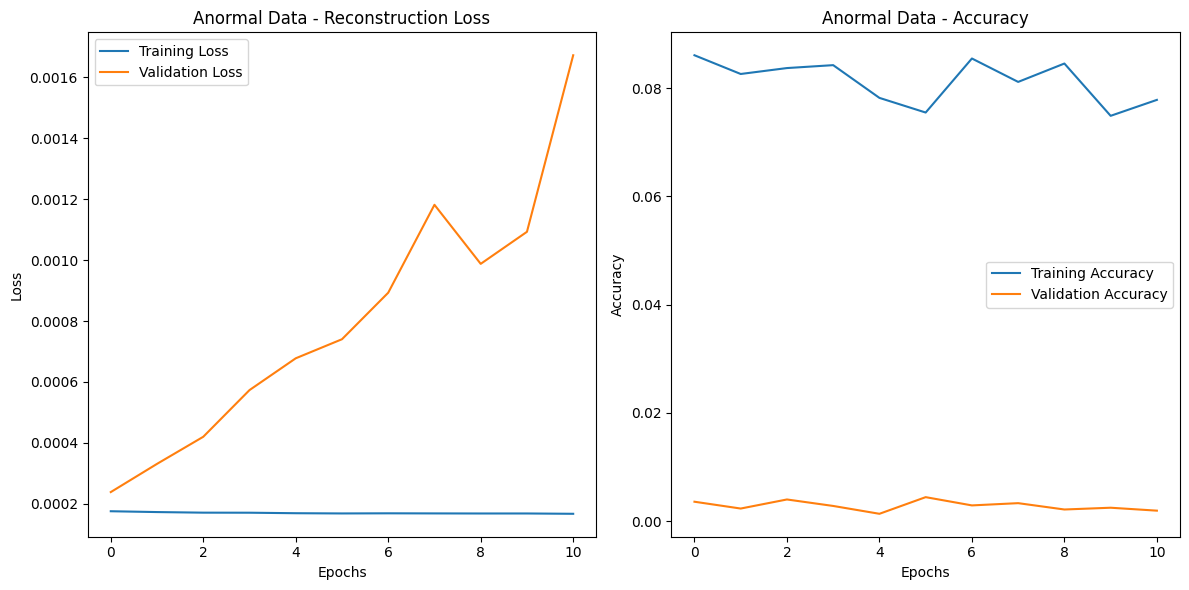

Training Autoencoder for Normal Data...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 119)]             0         
                                                                 
 encod1 (Dense)              (None, 32)                3840      
                                                                 
 encod2 (Dense)              (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 decoder1 (Dense)            (None, 32)                544       
                                                                 
 decoder3 (Dense)            (None, 119)               3927      
                                                                 
Total params: 8839 

Reloading Tuner from tuning_autoencoder1/not_anormal/autoencodernot_anormal/tuner0.json


Epoch 1/100
188/188 [==============================] - 4s 11ms/step - loss: 2.7870e-04 - acc: 0.1501 - val_loss: 2.5796e-04 - val_acc: 0.1106
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7040e-04 - acc: 0.1524 - val_loss: 2.6369e-04 - val_acc: 0.2803
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6815e-04 - acc: 0.1528 - val_loss: 2.5722e-04 - val_acc: 0.1137
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6696e-04 - acc: 0.1470 - val_loss: 2.6533e-04 - val_acc: 0.2919
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6821e-04 - acc: 0.1627 - val_loss: 2.5607e-04 - val_acc: 0.0764
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6166e-04 - acc: 0.1514 - val_loss: 2.6453e-04 - val_acc: 0.1274
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6328e-04 - acc: 0.1538 - val_loss: 2.6303e-04 - val_acc: 0.0904
Epoch 8/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


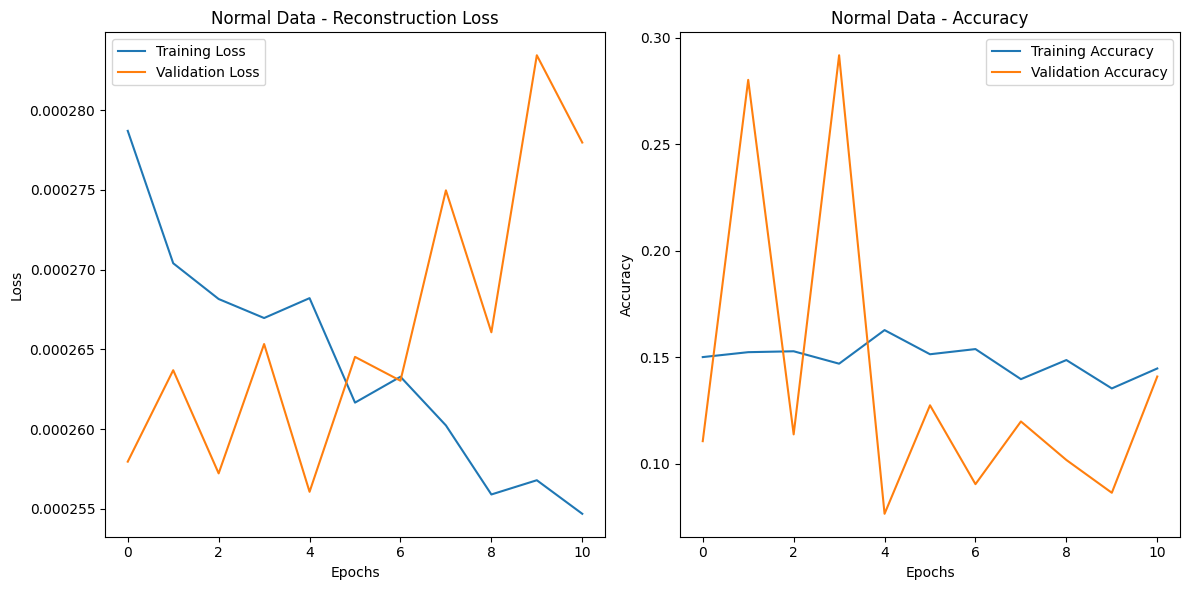

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    # Creazione di un grafico con due sotto-plot
    plt.figure(figsize=(12, 6))

    # Sotto-plot sinistro per la perdita
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Sotto-plot destro per l'accuratezza
    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ottimizzazione del layout e visualizzazione del grafico
    plt.tight_layout()
    plt.show()

# Esempio di utilizzo:

# Addestramento Autoencoder per dati Anomali
result_anormal = train_autoencoder(train_X_anormal, train_Y_anormal, test_X, test_Y, is_anormal=True)
plot_training_history(result_anormal['history'], 'Anormal Data')

# Addestramento Autoencoder per dati Normali
result_normal = train_autoencoder(train_X_normal, train_Y_normal, test_X, test_Y, is_anormal=False)
plot_training_history(result_normal['history'], 'Normal Data')


3040/3040 [==============================] - 5s 2ms/step


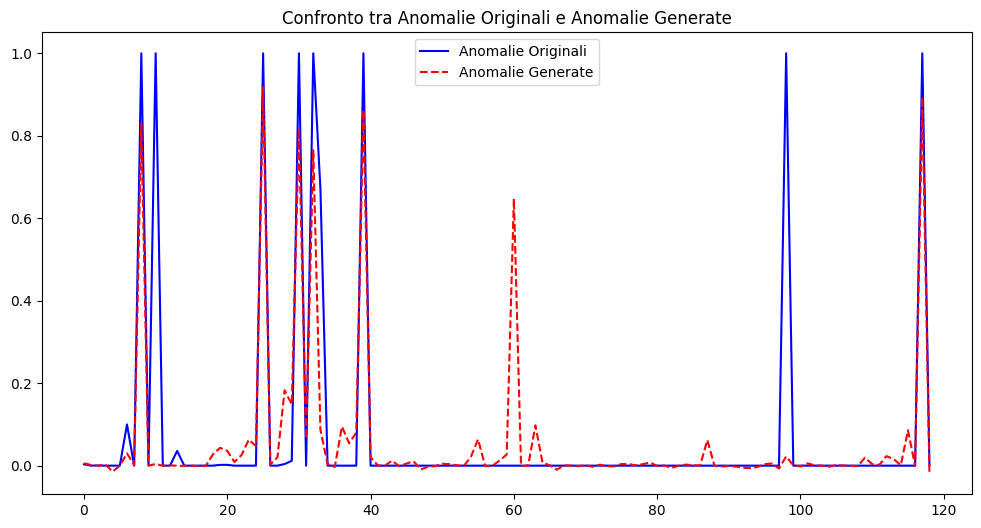

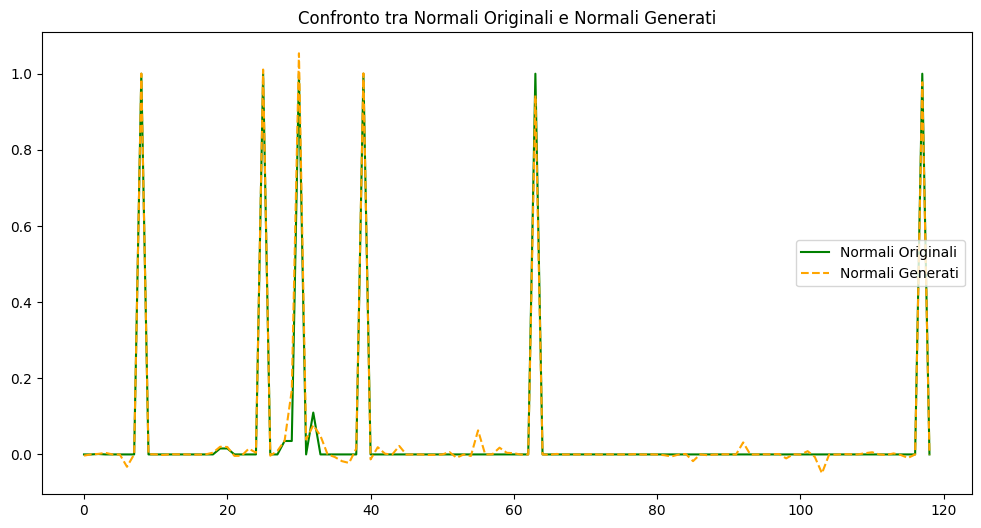

12399/12399 [==============================] - 22s 2ms/step


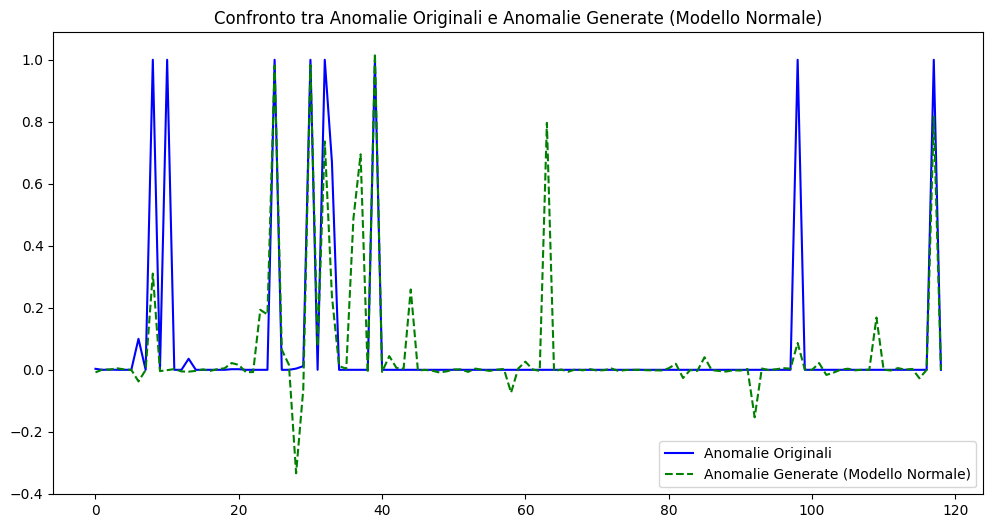

3040/3040 [==============================] - 6s 2ms/step


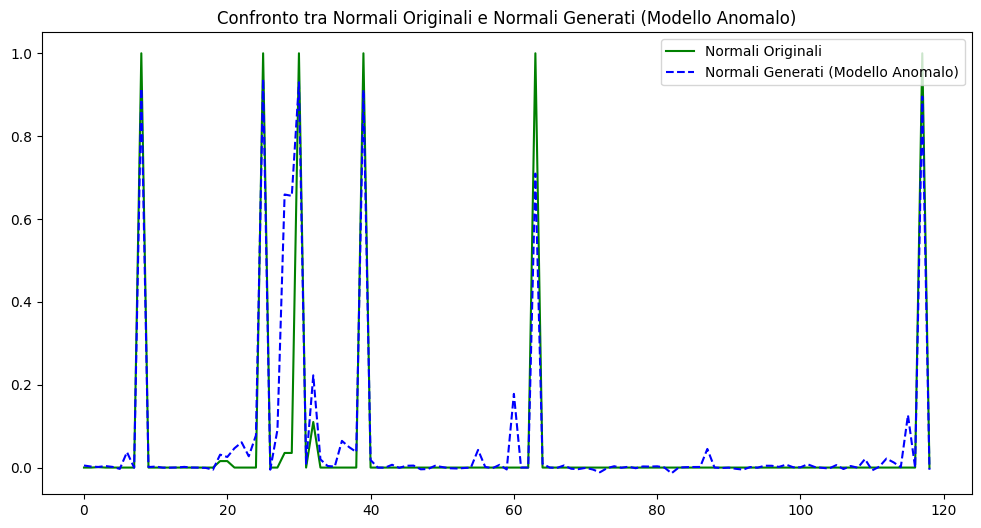

In [ ]:
from tensorflow.keras.models import load_model

# Carica i modelli autoencoder
anormal_autoencoder = load_model('autoencoder_anormal1.h5')
normal_autoencoder = load_model('autoencoder_normal1.h5')

# Ottieni le previsioni degli autoencoder
anormal_predictions = anormal_autoencoder.predict(train_X_anormal)
normal_predictions = normal_autoencoder.predict(train_X_normal)

# Scegli un esempio da visualizzare
example_index = 0

# Grafico del traffico originale e del traffico generato per l'esempio scelto (Anomalo)
plt.figure(figsize=(12, 6))
plt.plot(train_X_anormal[example_index], label='Anomalie Originali', linestyle='solid', color='blue')
plt.plot(anormal_predictions[example_index], label='Anomalie Generate', linestyle='dashed', color='red')
plt.title('Confronto tra Anomalie Originali e Anomalie Generate')
plt.legend()
plt.show()

# Grafico del traffico originale e del traffico generato per l'esempio scelto (Normale)
plt.figure(figsize=(12, 6))
plt.plot(train_X_normal[example_index], label='Normali Originali', linestyle='solid', color='green')
plt.plot(normal_predictions[example_index], label='Normali Generati', linestyle='dashed', color='orange')
plt.title('Confronto tra Normali Originali e Normali Generati')
plt.legend()
plt.show()

# Grafico del traffico originale e del traffico generato per l'esempio scelto (Anomalo con modello addestrato su dati normali)
plt.figure(figsize=(12, 6))
plt.plot(train_X_anormal[example_index], label='Anomalie Originali', linestyle='solid', color='blue')
plt.plot(normal_autoencoder.predict(train_X_anormal)[example_index], label='Anomalie Generate (Modello Normale)', linestyle='dashed', color='green')
plt.title('Confronto tra Anomalie Originali e Anomalie Generate (Modello Normale)')
plt.legend()
plt.show()

# Grafico del traffico originale e del traffico generato per l'esempio scelto (Normale con modello addestrato su dati anomali)
plt.figure(figsize=(12, 6))
plt.plot(train_X_normal[example_index], label='Normali Originali', linestyle='solid', color='green')
plt.plot(anormal_autoencoder.predict(train_X_normal)[example_index], label='Normali Generati (Modello Anomalo)', linestyle='dashed', color='blue')
plt.title('Confronto tra Normali Originali e Normali Generati (Modello Anomalo)')
plt.legend()
plt.show()



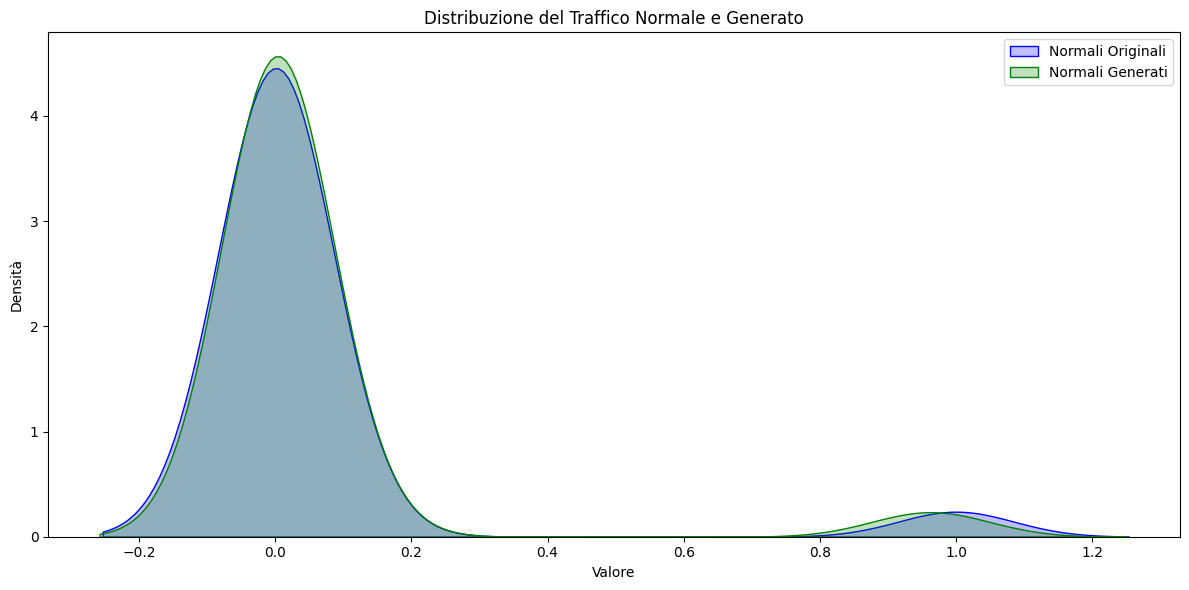

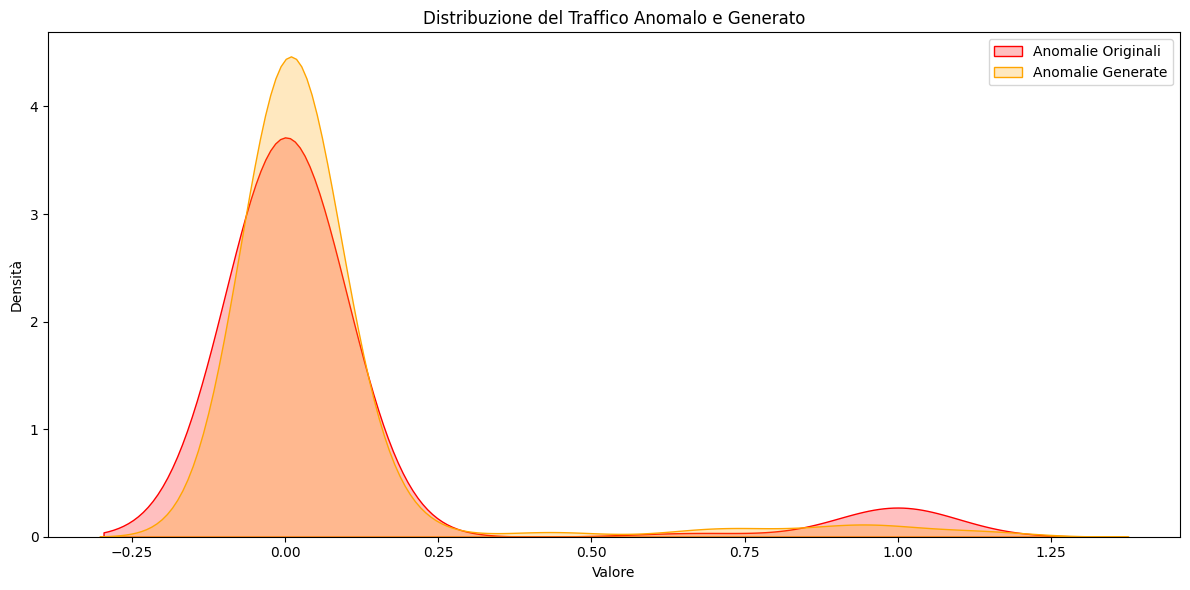

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grafico del traffico originale e del traffico generato per l'esempio scelto (Normale)
plt.figure(figsize=(12, 6))

# KDE plot per il traffico normale
sns.kdeplot(train_X_normal[example_index], label='Normali Originali', color='blue', fill=True)

# KDE plot per il traffico generato normale
sns.kdeplot(normal_predictions[example_index], label='Normali Generati', color='green', fill=True)

plt.title('Distribuzione del Traffico Normale e Generato')
plt.xlabel('Valore')
plt.ylabel('Densità')
plt.legend()

plt.tight_layout()
plt.show()

# Grafico del traffico originale e del traffico generato per l'esempio scelto (Anomalo)
plt.figure(figsize=(12, 6))

# KDE plot per il traffico anomalo
sns.kdeplot(train_X_anormal[example_index], label='Anomalie Originali', color='red', fill=True)

# KDE plot per il traffico generato anomalo
sns.kdeplot(anormal_predictions[example_index], label='Anomalie Generate', color='orange', fill=True)

plt.title('Distribuzione del Traffico Anomalo e Generato')
plt.xlabel('Valore')
plt.ylabel('Densità')
plt.legend()

plt.tight_layout()
plt.show()


# Sezione Siamese

## Creazione coppie positive e negative

*   Coppie positive: (anormal, anormal), (normal, normal) - Classe 1
*   Coppie negative: (normal, anormal) - Classe 0




In [ ]:
import numpy as np

def crea_coppie_bilanciate(x_normale, x_anormale, num_coppie_positive, num_coppie_negative):
    coppie = []
    etichette = []
    features_normale = x_normale
    features_anormale = x_anormale

    # Coppie positive (normale-normale, anomalo-anomalo)
    num_coppie_positive_per_classe = num_coppie_positive // 2
    indici_normale = np.random.randint(0, len(features_normale), size=(num_coppie_positive_per_classe))

    indici_anormale = np.random.randint(0, len(features_anormale), size=(num_coppie_positive_per_classe))

    for i in zip(indici_normale):
        coppie += [[features_normale[i[0]], features_normale[i[0]]]]
        etichette += [1]  # 1 indica una coppia genuina (normale, normale)

    for j in zip(indici_anormale):
        coppie += [[features_anormale[j[0]], features_anormale[j[0]]]]
        etichette += [1]  # 1 indica una coppia genuina (anomala, anomala)

    # Coppie negative (normale-anomalo)
    coppie_negative_univoche = set()
    while len(coppie_negative_univoche) < num_coppie_negative:
        indice_normale_random = np.random.choice(len(features_normale))
        indice_anormale_random = np.random.choice(len(features_anormale))

        coppia = (indice_normale_random, indice_anormale_random)
        if coppia not in coppie_negative_univoche:
            coppie += [[features_normale[indice_normale_random], features_anormale[indice_anormale_random]]]
            etichette += [0]  # 0 indica una coppia negativa (normale, anomalo)
            coppie_negative_univoche.add(coppia)

    X = np.array(coppie)
    Y = np.array(etichette)

    return X, Y

# Utilizza i dataset bilanciati
num_coppie_positive = 150000
num_coppie_negative = 150000

# Crea coppie bilanciate
X, Y = crea_coppie_bilanciate(train_X_normale, train_X_anormale, num_coppie_positive, num_coppie_negative)
print("Dimensioni delle coppie:", X.shape, Y.shape)


[61215 10899 86220 ... 41250 41178 31281]
[228057 390471 220265 ... 377705 311072   7843]
[0.00000000e+00 2.61041764e-07 1.05713002e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.56555773e-02
 1.56555773e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 3.52941176e-02 3.52941176e-02 1.00000000e+00 0.00000000e+00
 1.10000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

### Salvataggio dataset coppie

In [ ]:
import os
import numpy as np
import pandas as pd

def save_dataset_csv(X, Y, output_folder, filename_prefix):
    # Creare la cartella se non esiste
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Creare un DataFrame pandas con le coppie e le etichette
    columns = ['Pair', 'Label']

    # Creare una lista di coppie e relative etichette
    data = [[pair.tolist(), label] for pair, label in zip(X, Y)]

    # Creare il DataFrame dal dizionario di dati
    df = pd.DataFrame(data, columns=columns)

    # Specifica il percorso completo del file di output
    output_path = os.path.join(output_folder, f"{filename_prefix}_dataset.csv")

    # Salva il DataFrame in formato CSV
    df.to_csv(output_path, index=False)



    # Specifica la cartella e il prefisso del nome del file di output
output_folder = "KDDCUP99"
output_filename_prefix = "couple"

# Salva il dataset in formato CSV
save_dataset_csv(X, Y, output_folder, output_filename_prefix)

print(f"Dimensioni delle coppie: {X.shape}, {Y.shape}")
print(f"Dataset salvato in: {output_folder}/{output_filename_prefix}_dataset.csv")

Dimensioni delle coppie: (300000, 2, 119), (300000,)
Dataset salvato in: KDDCUP99/couple_dataset.csv


#### Caricamento dataset coppie

In [ ]:
import ast  # Modulo necessario per interpretare la rappresentazione testuale delle liste
import pandas as pd

def load_dataset_csv(file_path):
    # Carica il file CSV in un DataFrame
    df = pd.read_csv(file_path)

    # Estrai le coppie e le etichette
    X = df['Pair'].apply(lambda x: np.array(ast.literal_eval(x))).tolist()  # Converte la rappresentazione testuale della lista in un array
    Y = df['Label'].tolist()

    return X, Y


    # Specifica il percorso del file CSV
file_path = "KDDCUP99/couple_dataset.csv"

# Carica il dataset
X, Y = load_dataset_csv(file_path)

# Stampa le dimensioni di X e Y
print(f"Dimensioni di X: {len(X)}")
print(f"Dimensioni di Y: {len(Y)}")

#### Split dataset in training, validation and test

*   70% train
*   20% validation
*   10% test




In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train_siamese, x_temp_siamese, y_train_siamese, y_temp_siamese = train_test_split(X, Y, test_size=0.3, random_state=42)
x_validation_siamese, x_test_siamese, y_validation_siamese, y_test_siamese = train_test_split(x_temp_siamese, y_temp_siamese, test_size=1/3, random_state=42)

# Convertiamo le liste in array NumPy
x_train_siamese = np.array(x_train_siamese)
y_train_siamese = np.array(y_train_siamese)
x_validation_siamese = np.array(x_validation_siamese)
y_validation_siamese = np.array(y_validation_siamese)
x_test_siamese = np.array(x_test_siamese)
y_test_siamese = np.array(y_test_siamese)

# Stampa delle dimensioni dei set di training, validation e test
print("Dimensioni del set di training (siamese):", x_train_siamese.shape, y_train_siamese.shape)
print("Dimensioni del set di validation (siamese):", x_validation_siamese.shape, y_validation_siamese.shape)
print("Dimensioni del set di test (siamese):", x_test_siamese.shape, y_test_siamese.shape)


Dimensioni del set di training (siamese): (210000, 2, 119) (210000,)
Dimensioni del set di validation (siamese): (60000, 2, 119) (60000,)
Dimensioni del set di test (siamese): (30000, 2, 119) (30000,)


#### Salvataggio dataset splittato

In [ ]:
import os
import numpy as np

# Specifica la cartella e il prefisso del nome del file di output
output_folder = "KDDCUP99"
output_filename_prefix_train = "train_siamese"
output_filename_prefix_validation = "validation_siamese"
output_filename_prefix_test = "test_siamese"

# Specifica il percorso completo del file di output
output_path_train = os.path.join(output_folder, f"{output_filename_prefix_train}_X.npy")
output_path_validation = os.path.join(output_folder, f"{output_filename_prefix_validation}_X.npy")
output_path_test = os.path.join(output_folder, f"{output_filename_prefix_test}_X.npy")

# Salva gli array di training, validation e test in formato NumPy
np.save(output_path_train, x_train_siamese)
np.save(output_path_validation, x_validation_siamese)
np.save(output_path_test, x_test_siamese)

# Ora salva anche gli array delle etichette Y, se necessario
output_path_train_labels = os.path.join(output_folder, f"{output_filename_prefix_train}_Y.npy")
output_path_validation_labels = os.path.join(output_folder, f"{output_filename_prefix_validation}_Y.npy")
output_path_test_labels = os.path.join(output_folder, f"{output_filename_prefix_test}_Y.npy")

np.save(output_path_train_labels, y_train_siamese)
np.save(output_path_validation_labels, y_validation_siamese)
np.save(output_path_test_labels, y_test_siamese)


##### Test distanza euclidea tra due tensori

In [ ]:
import numpy as np
from keras import backend as K

# Definizione della funzione di distanza euclidea
def euclidean_distance(vects):
    x, y = vects
    distance_tensor = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance_tensor

# Esempio di utilizzo con due tensori
# Considera t1 e t2 come i tuoi tensori (coppie di feature)
t1 = np.array([[1.0, 2.0], [5.0, 6.0]])
t2 = np.array([[7.0, 8.0], [7.0, 8.0]])

# Converte i tensori in tensori Keras (nel caso tu stia utilizzando Keras)
t1_keras = K.variable(t1)
t2_keras = K.variable(t2)

# Calcola la distanza euclidea utilizzando la funzione definita
distances = K.eval(euclidean_distance([t1_keras, t2_keras]))

# Stampa le distanze calcolate
print("Distanze Euclidee tra le coppie:")
print(distances)


Distanze Euclidee tra le coppie:
[[8.485281]
 [2.828427]]


#### Caricamento dataset splittato


In [ ]:
import numpy as np

# Specifica il percorso completo dei file di input
input_folder = "KDDCUP99"
input_filename_prefix_train = "train_siamese"
input_filename_prefix_validation = "validation_siamese"
input_filename_prefix_test = "test_siamese"

# Carica gli array di training, validation e test dalla memoria
x_train_siamese = np.load(f"{input_folder}/{input_filename_prefix_train}_X.npy")
y_train_siamese = np.load(f"{input_folder}/{input_filename_prefix_train}_Y.npy")

x_validation_siamese = np.load(f"{input_folder}/{input_filename_prefix_validation}_X.npy")
y_validation_siamese = np.load(f"{input_folder}/{input_filename_prefix_validation}_Y.npy")

x_test_siamese = np.load(f"{input_folder}/{input_filename_prefix_test}_X.npy")
y_test_siamese = np.load(f"{input_folder}/{input_filename_prefix_test}_Y.npy")

# Stampa le dimensioni degli array caricati
print("Dimensioni di x_train_siamese_loaded:", x_train_siamese.shape)
print("Dimensioni di y_train_siamese_loaded:", y_train_siamese.shape)

print("Dimensioni di x_validation_siamese_loaded:", x_validation_siamese.shape)
print("Dimensioni di y_validation_siamese_loaded:", y_validation_siamese.shape)

print("Dimensioni di x_test_siamese_loaded:", x_test_siamese.shape)
print("Dimensioni di y_test_siamese_loaded:", y_test_siamese.shape)


Dimensioni di x_train_siamese_loaded: (210000, 2, 119)
Dimensioni di y_train_siamese_loaded: (210000,)
Dimensioni di x_validation_siamese_loaded: (60000, 2, 119)
Dimensioni di y_validation_siamese_loaded: (60000,)
Dimensioni di x_test_siamese_loaded: (30000, 2, 119)
Dimensioni di y_test_siamese_loaded: (30000,)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Combina i dati di input e output del test set
test_data = np.hstack([x_test_siamese, y_test_siamese.reshape(-1, 1)])

# Riduci le dimensioni utilizzando PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(test_data)

# Separa le coppie simili e dissimili
simile_pairs = reduced_features[y_test_siamese == 1]
dissimile_pairs = reduced_features[y_test_siamese == 0]

# Crea una visualizzazione a dispersione
plt.scatter(simile_pairs[:, 0], similar_pairs[:, 1], label='Simili', color='blue', marker='.')
plt.scatter(dissimile_pairs[:, 0], dissimile_pairs[:, 1], label='Dissimili', color='red', marker='.')

# Aggiungi etichette
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribuzione di Coppie Simili e Dissimili nel Dataset di Test')

# Aggiungi la legenda
plt.legend()

# Mostra il grafico
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

#### Test Euclidian Distance sui dataset di coppie negative/positive

In [ ]:
import numpy as np
from keras import backend as K

# Definizione della funzione di distanza euclidea
def euclidean_distance(vects):
    x, y = vects
    distance_tensor = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance_tensor


# Trova gli indici degli esempi in x_train per la classe 0 (dissimile)
indices_dissimilar = np.where(y_train_siamese == 0)[0]

# Estrai gli esempi corrispondenti da x_train_siamese
x_train_dissimilar = x_train_siamese[indices_dissimilar]

# Calcola la distanza euclidea utilizzando la tua funzione
distance_result_dissimilar = euclidean_distance([x_train_dissimilar[:, 0], x_train_dissimilar[:, 1]])

# Calcola la media delle distanze per la classe 0
average_distance_dissimilar = np.mean(distance_result_dissimilar)

print(f"Media della distanza euclidea tra esempi dissimili (classe 0): {average_distance_dissimilar}")


# Trova gli indici degli esempi in x_train per la classe 1 (simile)
indices_similar = np.where(y_train_siamese == 1)[0]

# Estrai gli esempi corrispondenti da x_train_siamese
x_train_similar = x_train_siamese[indices_similar]

# Calcola la distanza euclidea utilizzando la tua funzione
distance_result_similar = euclidean_distance([x_train_similar[:, 0], x_train_similar[:, 1]])

# Calcola la media delle distanze per la classe 1
average_distance_similar = np.mean(distance_result_similar)

print(f"Media della distanza euclidea tra esempi simili (classe 1): {average_distance_similar}")

Media della distanza euclidea tra esempi dissimili (classe 0): 3.0543681114840076
Media della distanza euclidea tra esempi simili (classe 1): 0.0003162277660168381


## Tuning of Siaemse model

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
import keras
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import plot_model
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters


# Assuming you have defined the input shape
input_shape = x_train_siamese.shape[2:]

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    y_true = K.cast(y_true, dtype='float32')  # Explicit cast to float32
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))  # Fix: Add 0 as the second argument
    return K.mean((1 - y_true) * square_pred + y_true * margin_square)

def accuracy(y_true, y_pred):
    '''Calcola l'accuratezza della classificazione con una soglia fissa sulle distanze.'''
    y_true = K.cast(y_true, dtype='float32')

    # Confronta la previsione con una soglia fissa per determinare la correttezza
    y_predVett = K.cast(y_pred > 0.45, y_true.dtype)

    # Calcola la media delle corrispondenze corrette per l'accuratezza
    return K.mean(K.equal(y_true, y_predVett))


def build_siamese_model(hp):
      # Define a shared embedding network
      shared_dense_1 = Dense(hp.Int('dense_1_units', min_value=128, max_value=512, step=64), activation='relu')
      shared_dropout_1 = Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))
      shared_dense_2 = Dense(hp.Int('dense_2_units', min_value=128, max_value=512, step=64), activation='relu')
      shared_dropout_2 = Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1))
      shared_dense_3 = Dense(hp.Int('dense_3_units', min_value=119, max_value=1024, step=119), activation='relu')

      # Define input layers
      input_a = Input(shape=input_shape, name='input_a')
      input_b = Input(shape=input_shape, name='input_b')

      # Shared embedding network
      dense_1_a = shared_dense_1(input_a)
      dropout_1_a = shared_dropout_1(dense_1_a)
      dense_2_a = shared_dense_2(dropout_1_a)
      dropout_2_a = shared_dropout_2(dense_2_a)
      dense_3_a = shared_dense_3(dropout_2_a)

      dense_1_b = shared_dense_1(input_b)
      dropout_1_b = shared_dropout_1(dense_1_b)
      dense_2_b = shared_dense_2(dropout_1_b)
      dropout_2_b = shared_dropout_2(dense_2_b)
      dense_3_b = shared_dense_3(dropout_2_b)

      # Compute the Euclidean distance
      distance = Lambda(euclidean_distance, output_shape=(1,), name='distance')([dense_3_a, dense_3_b])

      # Single dropout layer after the distance calculation
      x = Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1))(distance)
      out = Dense(1, activation="sigmoid", name='out')(x)

      # Build the model
      model = Model(inputs=[input_a, input_b], outputs=out)

      # Compile the model
      optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

      model.compile(
        optimizer=optimizer,
          loss=contrastive_loss,
          metrics=[accuracy]
     )


      # Visualize the model without saving the file
      plot_model(model, show_shapes=True, show_layer_names=True)


      return model



# Crea un oggetto HyperParameters
hp = HyperParameters()

# Aggiungi iperparametri al tuo oggetto hp
hp.Int('batch_size', min_value=16, max_value=64, step=16)

# Instantiate the Hyperband tuner
tuner = kt.Hyperband(
    build_siamese_model,
    objective='val_loss',
    hyperparameters=hp,
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,
    directory='hyperband',
    project_name='siamese_tuner'
)

# Perform the hyperparameter search
tuner.search_space_summary()
# Provide your input and target data
tuner.search(x=[x_train_siamese[:, 0], x_train_siamese[:, 1]],
             y=y_train_siamese,
             epochs=10,
             validation_data=([x_validation_siamese[:, 0], x_validation_siamese[:, 1]], y_validation_siamese))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = build_siamese_model(best_hps)

# Train the model with the best hyperparameters on all available data
history = best_model.fit(
    [x_train_siamese[:, 0], x_train_siamese[:, 1]],
    y_train_siamese,
    epochs=10,  # Numero di epoche da specificare
    batch_size=best_hps.get('batch_size'),
    validation_data=([x_validation_siamese[:, 0], x_validation_siamese[:, 1]], y_validation_siamese)
)



### Salvataggio del modello migliore

In [ ]:
# Save the entire model (architecture, weights, and optimizer state)
best_model.save('best_siamese_model.h5')

### Grafico della storia di training della Siamese

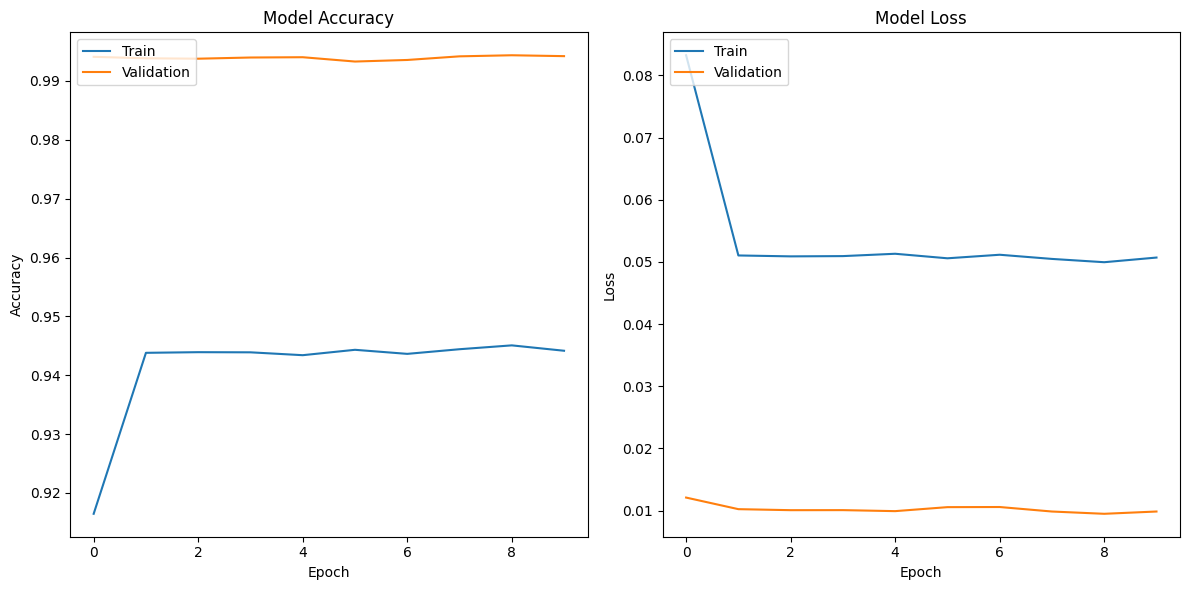

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Caricamento del modello pre-addestrato
- Va caricata anche la funzione contrastive_loss altrimenti dà errore

In [ ]:
from keras.models import load_model
from keras import backend as K
from tensorflow.keras.utils import plot_model

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = K.cast(y_true, dtype='float32')
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + y_true * margin_square)

def accuracy(y_true, y_pred):
    '''Calcola l'accuratezza della classificazione con una soglia fissa sulle distanze.'''
    y_true = K.cast(y_true, dtype='float32')

    # Confronta la previsione con una soglia fissa per determinare la correttezza
    y_predVett = K.cast(y_pred > 0.45, y_true.dtype)

    # Calcola la media delle corrispondenze corrette per l'accuratezza
    return K.mean(K.equal(y_true, y_predVett))


# Assuming x_test_siamese, y_test_siamese are defined earlier in your code

# Load the saved model
siamese = load_model('best_siamese_model.h5', custom_objects={'contrastive_loss': contrastive_loss})


# Display the model summary
siamese.summary()


# Plot the Siamese model
plot_model(siamese, to_file='siamese_model_oneshot.png', show_shapes=True, show_layer_names=True)





Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_a (InputLayer)        [(None, 119)]                0         []                            
                                                                                                  
 input_b (InputLayer)        [(None, 119)]                0         []                            
                                                                                                  
 dense_45 (Dense)            (None, 448)                  53760     ['input_a[0][0]',             
                                                                     'input_b[0][0]']             
                                                                                                  
 dropout_45 (Dropout)        (None, 448)                  0         ['dense_45[0][0]',     

## Accuracy sul set di Validation (Coppie)

1875/1875 [==============================] - 14s 7ms/step
Accuracy on Validation Set:  0.9966333333333334
Precision on Validation Set:  0.99328524415783
Recall on Validation Set:  1.0
F1-Score on Validation Set:  0.9966313121206056


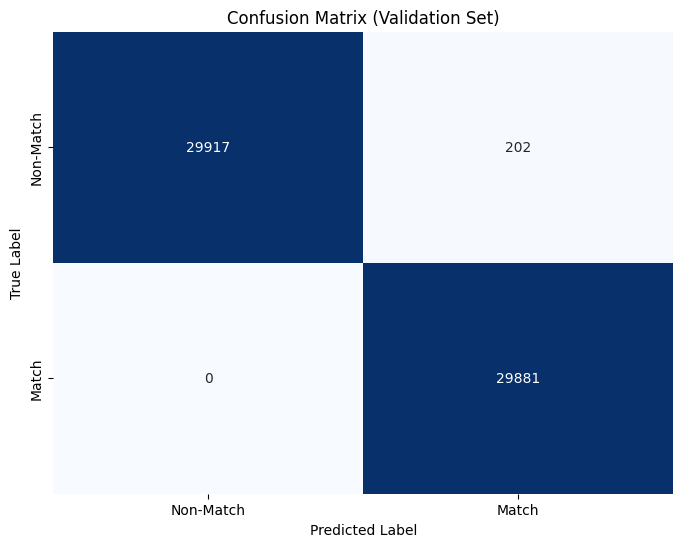

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


# Get predictions from the model on the validation set
y_val_pred = siamese.predict([x_validation_siamese[:, 0], x_validation_siamese[:, 1]])

threshold = 0.45

# Consider a match if the prediction is greater than the threshold
val_predicted_labels = (y_val_pred > threshold).astype(int)

# Calculate accuracy on the validation set
val_accuracy = accuracy_score(y_validation_siamese, val_predicted_labels)
print('Accuracy on Validation Set: ', val_accuracy)

# Calculate other metrics if needed for the validation set
val_conf_matrix = confusion_matrix(y_validation_siamese, val_predicted_labels)


# Calculate precision, recall, and F1-score for the validation set
val_precision = precision_score(y_validation_siamese, val_predicted_labels)
val_recall = recall_score(y_validation_siamese, val_predicted_labels)
val_f1 = f1_score(y_validation_siamese, val_predicted_labels)

print('Precision on Validation Set: ', val_precision)
print('Recall on Validation Set: ', val_recall)
print('F1-Score on Validation Set: ', val_f1)

# Plot the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Match', 'Match'], yticklabels=['Non-Match', 'Match'])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Accuracy sul set di Test (Coppie)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming x_test_siamese, y_test_siamese, siamese, and threshold are defined earlier in your code

# Get predictions from the model on the test set
y_test_pred = siamese.predict([x_test_siamese[:, 0], x_test_siamese[:, 1]])

# Consider a match if the prediction is greater than the threshold
test_predicted_labels = (y_test_pred > threshold).astype(int)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test_siamese, test_predicted_labels)
print('Accuracy on Test Set: ', test_accuracy)

# Calculate other metrics for the test set
test_conf_matrix = confusion_matrix(y_test_siamese, test_predicted_labels)

# Calculate precision, recall, and F1-score for the test set
test_precision = precision_score(y_test_siamese, test_predicted_labels)
test_recall = recall_score(y_test_siamese, test_predicted_labels)
test_f1 = f1_score(y_test_siamese, test_predicted_labels)

print('Precision on Test Set: ', test_precision)
print('Recall on Test Set: ', test_recall)
print('F1-Score on Test Set: ', test_f1)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Match', 'Match'], yticklabels=['Non-Match', 'Match'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


NameError: name 'siamese' is not defined

In [ ]:
print(train_XA[0, :].shape)

(119,)


#Sezione Anomaly Detection System

## Split test general of KDDCUP in 0.01%


*   311.029 original * 0,01 = 3111



In [ ]:
from sklearn.model_selection import train_test_split

# X è la matrice delle features, y è l'array delle etichette/target
x_train_ridotto, x_test_ridotto, y_train_ridotto, y_test_ridotto = train_test_split(test_X, test_Y, test_size=0.01, random_state=None)

print(x_test_ridotto.shape)

(3111, 119)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import load_model

class AnomalyDetectionModel:



    def __init__(self):
        # Set the path to models in the class
        self.path_models = "/content/drive/MyDrive/RetiGeografiche-Progetto/RENOIR/models/KDDCUP99/"
        self.threshold = 0.47010604

        def contrastive_loss(y_true, y_pred):
          margin = 1
          y_true = K.cast(y_true, dtype='float32')
          square_pred = K.square(y_pred)
          margin_square = K.square(K.maximum(margin - y_pred, 0))
          return K.mean((1 - y_true) * square_pred + y_true * margin_square)

        # Load autoencoder models
        self.autoencoderA = load_model('autoencoder_anormal.h5')
        self.autoencoderN = load_model('autoencoder_normal1.h5')
        self.siamese_modelA = load_model('best_siamese_model.h5', custom_objects={'contrastive_loss': contrastive_loss})
        self.siamese_modelN = load_model('best_siamese_model.h5', custom_objects={'contrastive_loss': contrastive_loss})

    def predict(self, sample_traffic):
        # Ensure sample_traffic has the expected shape
        sample_traffic = sample_traffic.reshape(1, -1)

        # Get latent representations using autoencoders
        latent_representation_normal = self.autoencoderN.predict(sample_traffic)
        latent_representation_anomalous = self.autoencoderA.predict(sample_traffic)

        # Build input data for the Siamese model
        siamese_input_normal = [sample_traffic, latent_representation_normal]
        siamese_input_anomalous = [sample_traffic, latent_representation_anomalous]

       # Evaluate the Siamese model to get Euclidean distances
        score_normal = self.siamese_modelN.predict(siamese_input_normal)[0]
        score_anormal = self.siamese_modelA.predict(siamese_input_anomalous)[0]

        # Print the scores
        print(f'Score for Normal: {score_normal}')
        print(f'Score for Anomalous: {score_anormal}')

        # Effettua la predizione basata sulla soglia
        if score_normal >= score_anormal:
            return 1 # Normale
        else:
            return 0 # Anomalo

# Create an instance of the AnomalyDetectionModel
anomaly_detection_model = AnomalyDetectionModel()

# Lists to save predictions and true labels
predictions = []
true_labels = []

# Iterating through the entire test set
for sample_traffic, true_label in zip(x_test_ridotto, y_test_ridotto):
    print(30*'-')
    print(f'Mi aspetto: {true_label}')
    classification = anomaly_detection_model.predict(sample_traffic)
    predictions.append(classification)
    true_labels.append(true_label)
    print(30*'-')

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Calculate confusion matrix to get TP, FP, TN, FN
conf_matrix = confusion_matrix(true_labels, predictions)
print(conf_matrix)

# Print metrics and confusion matrix measures
print("Accuracy library on test set:", accuracy)
print("Precision library on test set:", precision)
print("Recall library on test set:", recall)
print("F1-score library on test set:", f1)

def getResult(t, cm, N_CLASSES):
    tp = cm[0][0]
    fn = cm[1][0]
    fp = cm[0][1]
    tn = cm[1][1]
    attacks = fp + tn  # Totali normali predetti come attacchi
    normals = tp + fn
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / normals) + (tn / attacks)) / N_CLASSES
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [t, tp, fn, fp, tn, OA, AA, P, R, F1, FAR, TPR]
    return r

result_metrics = getResult("AnomalyDetSystem", conf_matrix, 2)
# Print additional metrics
columns = ['Method', 'TP', 'FN', 'FP', 'TN', 'OA', 'AA', 'Precision', 'Recall', 'F1', 'FAR', 'TPR']
results_df = pd.DataFrame([result_metrics], columns=columns)
print(results_df)

'''
# Save results to a file
with open("anomaly_detection_results-.txt", "w") as file:
    file.write("Accuracy on test set: {}\n".format(accuracy))
    file.write("Precision on test set: {}\n".format(precision))
    file.write("Recall on test set: {}\n".format(recall))
    file.write("F1-score on test set: {}\n".format(f1))


print("Results saved to 'anomaly_detection_results.txt'")
'''


------------------------------
Mi aspetto: 0
1/1 [==============================] - 0s 270ms/step
Score for Normal: [0.90320396]
Score for Anomalous: [0.01348321]
------------------------------
------------------------------
Mi aspetto: 1
1/1 [==============================] - 0s 46ms/step
Score for Normal: [0.90320396]
Score for Anomalous: [0.01348321]
------------------------------
------------------------------
Mi aspetto: 0
1/1 [==============================] - 0s 32ms/step
Score for Normal: [0.01348321]
Score for Anomalous: [0.90320396]
------------------------------
------------------------------
Mi aspetto: 0
1/1 [==============================] - 0s 28ms/step
Score for Normal: [0.01348321]
Score for Anomalous: [0.90320396]
------------------------------
------------------------------
Mi aspetto: 0
1/1 [==============================] - 0s 32ms/step
Score for Normal: [0.01348321]
Score for Anomalous: [0.90320396]
------------------------------
------------------------------
Mi 

'\n# Save results to a file\nwith open("anomaly_detection_results-.txt", "w") as file:\n    file.write("Accuracy on test set: {}\n".format(accuracy))\n    file.write("Precision on test set: {}\n".format(precision))\n    file.write("Recall on test set: {}\n".format(recall))\n    file.write("F1-score on test set: {}\n".format(f1))\n\n\nprint("Results saved to \'anomaly_detection_results.txt\'")\n'

In [ ]:
!pip install tqdm

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import load_model
from tqdm import tqdm

class AnomalyDetectionModel:

    def contrastive_loss(y_true, y_pred):
        margin = 1
        y_true = K.cast(y_true, dtype='float32')
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean((1 - y_true) * square_pred + y_true * margin_square)

    def __init__(self):
        self.path_models = "/content/drive/MyDrive/RetiGeografiche-Progetto/RENOIR/models/KDDCUP99/"
        self.threshold = 0.47010604

        # Load autoencoder models
        self.autoencoderA = load_model('autoencoder_anormal.h5')
        self.autoencoderN = load_model('autoencoder_normal1.h5')
        self.siamese_model = load_model('best_siamese_model.h5', custom_objects={'contrastive_loss': self.contrastive_loss})
        self.siamese_modelN = load_model('best_siamese_model.h5', custom_objects={'contrastive_loss': self.contrastive_loss})

    def predict(self, sample_traffic):
        # Ensure sample_traffic has the expected shape
        sample_traffic = sample_traffic.reshape(1, -1)

        # Get latent representations using autoencoders
        latent_representation_normal = self.autoencoderN.predict(sample_traffic)
        latent_representation_anomalous = self.autoencoderA.predict(sample_traffic)

        # Build input data for the Siamese model
        siamese_input_normal = [latent_representation_normal, sample_traffic]
        siamese_input_anomalous = [latent_representation_anomalous, sample_traffic]

       # Evaluate the Siamese model to get Euclidean distances
        score_normal = self.siamese_model.predict(siamese_input_normal)[0]
        score_anormal = self.siamese_model.predict(siamese_input_anomalous)[0]

        # Print the scores
        print(f'Score for Normal: {score_normal}')
        print(f'Score for Normal: {score_anormal}')

        # Effettua la predizione basata sulla soglia
        if score_normal > 0.5:
            print("Classe 1 (Simile - Normale)")
            return 1 # Normale
        else:
            print("Classe 0 (Dissimile - Anormale)")
            return 0 # Anomalo

# Create an instance of the AnomalyDetectionModel
anomaly_detection_model = AnomalyDetectionModel()

# Lists to save predictions and true labels
predictions = []
true_labels = []

# Creazione della barra di avanzamento
progress_bar = tqdm(total=len(x_test_ridotto), desc="Elaborazione del test set")

# Iterazione attraverso l'intero set di test
for sample_traffic, true_label in zip(x_test_ridotto, y_test_ridotto):
    print("Mi aspetto: ", true_label)

    # Chiamata alla funzione di predizione o classificazione
    classification = anomaly_detection_model.predict(sample_traffic)

    # Aggiornamento della barra di avanzamento
    progress_bar.update(1)

    # Altri passaggi o salvataggio dei risultati, se necessario
    predictions.append(classification)
    true_labels.append(true_label)

# Chiusura della barra di avanzamento
progress_bar.close()

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Calculate confusion matrix to get TP, FP, TN, FN
conf_matrix = confusion_matrix(true_labels, predictions)

# Print metrics and confusion matrix measures
print("Accuracy on test set:", accuracy)
print("Precision on test set:", precision)
print("Recall on test set:", recall)
print("F1-score on test set:", f1)



# Save results to a file
with open("anomaly_detection_results.txt", "w") as file:
    file.write("Accuracy on test set: {}\n".format(accuracy))
    file.write("Precision on test set: {}\n".format(precision))
    file.write("Recall on test set: {}\n".format(recall))
    file.write("F1-score on test set: {}\n".format(f1))



def getResult(t, cm, N_CLASSES):
    tp = cm[0][0]
    fn = cm[1][0]
    fp = cm[0][1]
    tn = cm[1][1]
    attacks = fp + tn  # Totali normali predetti come attacchi
    normals = tp + fn
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / normals) + (tn / attacks)) / N_CLASSES
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [t, tp, fn, fp, tn, OA, AA, P, R, F1, FAR, TPR]
    return r


# Calculate additional metrics using getResult function
result_metrics = getResult('Embedding', conf_matrix, 2)

# Print additional metrics
columns = ['Method', 'TP', 'FN', 'FP', 'TN', 'OA', 'AA', 'Precision', 'Recall', 'F1', 'FAR', 'TPR']
results_df = pd.DataFrame([result_metrics], columns=columns)
print(results_df)

# Save results to a file
with open("additional_metrics_results.txt", "w") as file:
    file.write("Method: {}\n".format(result_metrics['Method']))
    file.write("TP: {}\n".format(result_metrics['TP']))
    file.write("FN: {}\n".format(result_metrics['FN']))
    file.write("FP: {}\n".format(result_metrics['FP']))
    file.write("TN: {}\n".format(result_metrics['TN']))
    file.write("OA: {}\n".format(result_metrics['OA']))
    file.write("AA: {}\n".format(result_metrics['AA']))
    file.write("Precision: {}\n".format(result_metrics['Precision']))
    file.write("Recall: {}\n".format(result_metrics['Recall']))
    file.write("F1: {}\n".format(result_metrics['F1']))
    file.write("FAR: {}\n".format(result_metrics['FAR']))
    file.write("TPR: {}\n".format(result_metrics['TPR']))

print("Results saved to 'anomaly_detection_results.txt' and 'additional_metrics_results.txt'")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the plot as an image file
plt.savefig('confusion_matrix_plot1000.png')

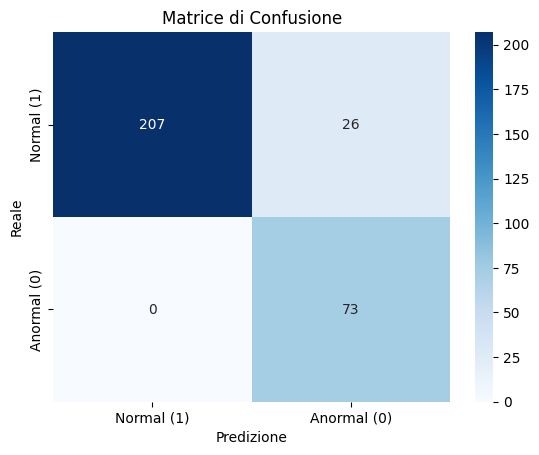

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Definisci la matrice di confusione
conf_matrix = np.array([[207, 26],
                        [0, 73]])

# Etichette delle classi
class_labels = ["Normal (1)", "Anormal (0)"]

# Creazione della heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Aggiungi etichette e titolo
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')

# Mostra la heatmap
plt.show()


## Esperimento 1: Anomaly Detection System
- Due autoencoder Normal e Anormal
- Due reti siamese

Il traffico X passa attraverso l'autoencoder Normal il quale ricostruisce X', si crea la coppia (X, x'). Il traffico X passa anche attraverso l'autoencoder Anormal, il quale ricostruisce X'', si crea la coppia (X,X''). Le coppie (X,X') e (X,X'') vanno in input a due siamesi che generano un punteggio di similarità S_N (riferimento alla rappresentazione Normal) e S_A (riferimento alla rappresentazione Anormal). Se S_N > S_A il traffico è normale (Classe 1) altrimenti 0.

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 23ms/step
Score for Normal: [0.01348321]
Score for Anomalous: [0.90320396]
Predict: 0 (Anomalous)
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 26ms/step
Score for Normal: [0.90320396]
Score for Anomalous: [0.90320396]
Predict: 1 (Normal)
Expected Label: 1
------------------------------
------------------------------
1/1 [==============================] - 0s 28ms/step
Score for Normal: [0.01348321]
Score for Anomalous: [0.90320396]
Predict: 0 (Anomalous)
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 39ms/step
Score for Normal: [0.90320396]
Score for Anomalous: [0.01348321]
Predict: 1 (Normal)
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 34ms/step
Score for Normal: [0.013

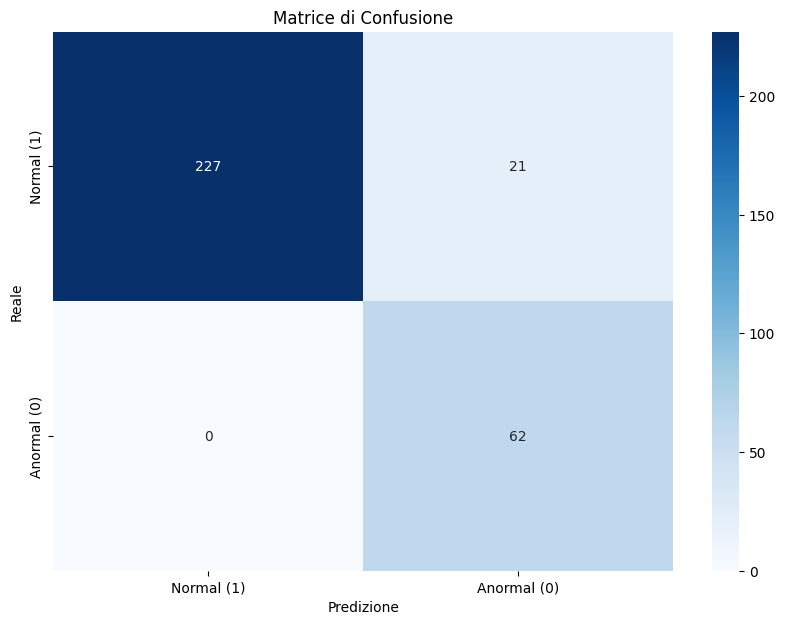

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as K
import seaborn as sns


class AnomalyDetectionModel:

    def contrastive_loss(y_true, y_pred):
        margin = 1
        y_true = K.cast(y_true, dtype='float32')
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean((1 - y_true) * square_pred + y_true * margin_square)

    def __init__(self):

        # Load autoencoder models
        self.autoencoderA = load_model('./models/autoencoder_anormal1.h5')
        self.autoencoderN = load_model('./models/autoencoder_normal1.h5')
        self.siamese_modelA = load_model('./models/best_siamese_model.h5', custom_objects={'contrastive_loss': self.contrastive_loss})
        self.siamese_modelN = load_model('./models/best_siamese_model.h5', custom_objects={'contrastive_loss': self.contrastive_loss})

    def predict(self, sample_traffic):
        # Ensure sample_traffic has the expected shape
        sample_traffic = sample_traffic.reshape(1, -1)

        # Get latent representations using autoencoders
        latent_representation_normal = self.autoencoderN.predict(sample_traffic)
        latent_representation_anomalous = self.autoencoderA.predict(sample_traffic)

        # Build input data for the Siamese model
        siamese_input_normal = [sample_traffic, latent_representation_normal]
        siamese_input_anomalous = [sample_traffic, latent_representation_anomalous]

        # Evaluate the Siamese model to get Euclidean distances
        score_normal = self.siamese_modelN.predict(siamese_input_normal)[0]
        score_anomalous = self.siamese_modelA.predict(siamese_input_anomalous)[0]

        # Print the scores
        print(f'Score for Normal: {score_normal}')
        print(f'Score for Anomalous: {score_anomalous}')

        # Make prediction based on the threshold
        if score_normal >= score_anomalous:
            print("Predict: 1 (Normal)")
            return 1  # Normal
        else:
            print("Predict: 0 (Anomalous)")
            return 0  # Anomalous

def evaluate_anomaly_detection_model(model, x_subset, y_subset):
    predictions = []
    true_labels = []

    for sample_traffic, true_label in zip(x_subset, y_subset):
        print(30*"-")
        classification = model.predict(sample_traffic)
        print("Expected Label:", true_label)
        predictions.append(classification)
        true_labels.append(true_label)
        print(30*"-")

    # Calculate metrics for the current subset
    confusion_mat = confusion_matrix(true_labels, predictions)
    print(confusion_mat)

    return confusion_mat

def getResult(t, cm, N_CLASSES):
    tp = cm[0][0]
    fn = cm[1][0]
    fp = cm[0][1]
    tn = cm[1][1]
    attacks = fp + tn  # Totali normali predetti come attacchi
    normals = tp + fn
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / normals) + (tn / attacks)) / N_CLASSES
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [t, tp, fn, fp, tn, OA, AA, P, R, F1, FAR, TPR]
    return r


# Create an instance of the AnomalyDetectionModel
anomaly_detection_model = AnomalyDetectionModel()

# Lists to save average metrics over runs
average_accuracy = []
average_precision = []
average_recall = []
average_f1 = []
average_confusion_matrix = np.zeros((2, 2), dtype=int)

runs = 10

for _ in range(runs):
    # Random state None selects different results across different executions
    _, x_subset,_,y_subset = train_test_split(test_X, test_Y, test_size=0.001, random_state=None)

    # Evaluate the model for the current subset
    confusion_mat = evaluate_anomaly_detection_model(anomaly_detection_model, x_subset, y_subset)

    average_confusion_matrix += confusion_mat

# Calculate average metrics over runs
average_confusion_matrix = average_confusion_matrix // runs  # Average the confusion matrix


# Print average confusion matrix
print("Average Confusion Matrix:")
print(average_confusion_matrix)

# Save average results to a file
filename = f"esperimento1_anomaly_detection_results-{runs}.txt"
# Calcola i risultati utilizzando la funzione getResult
r = getResult('Esperimento1', average_confusion_matrix, 2)
columns = ['Method', 'TP', 'FN', 'FP', 'TN', 'OA', 'AA', 'Precision', 'Recall', 'F1', 'FAR', 'TPR']
results_df = pd.DataFrame([r], columns=columns)
print(results_df)

with open(filename, "w") as file:
    results_df.to_csv(file, index=False, header=file.tell()==0)

print(f"Average results saved to '{filename}'")

import matplotlib.pyplot as plt

# Stampa la matrice di confusione media
plt.figure(figsize=(10, 7))
plt.title(f'Average Confusion Matrix over {runs} Runs')
# Etichette delle classi
class_labels = ["Normal (1)", "Anormal (0)"]

# Creazione della heatmap
sns.heatmap(average_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Aggiungi etichette e titolo
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')

# Mostra la heatmap
plt.show()



## Esperimento 2: Anomaly Detection System
- Un autoencoder Normal
- Una rete siamese

Il traffico X passa attraverso l'autoencoder Normal il quale ricostruisce X', si crea la coppia (X, x'). La coppie (X,X') va in input alla rete siamese che genera un punteggio di similarità S_N (riferimento alla rappresentazione Normal). Se S_N > soglia (fissata a 0,45) il traffico è normale (Classe 1) altrimenti 0.

-------------------- Range :  9 --------------------
SHAPE:  (312, 119)
------------------------------
1/1 [==============================] - 0s 23ms/step
Score for Normal: [0.01348321]
Predict: 0 (Anomalous)
Chiamata numero: 1
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 22ms/step
Score for Normal: [0.90320396]
Predict: 1 (Normal)
Chiamata numero: 2
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 24ms/step
Score for Normal: [0.90320396]
Predict: 1 (Normal)
Chiamata numero: 3
Expected Label: 1
------------------------------
------------------------------
1/1 [==============================] - 0s 24ms/step
Score for Normal: [0.90320396]
Predict: 1 (Normal)
Chiamata numero: 4
Expected Label: 1
------------------------------
------------------------------
1/1 [==============================] - 0s 23ms/step
Score for Normal: [0.01348321]
Pre

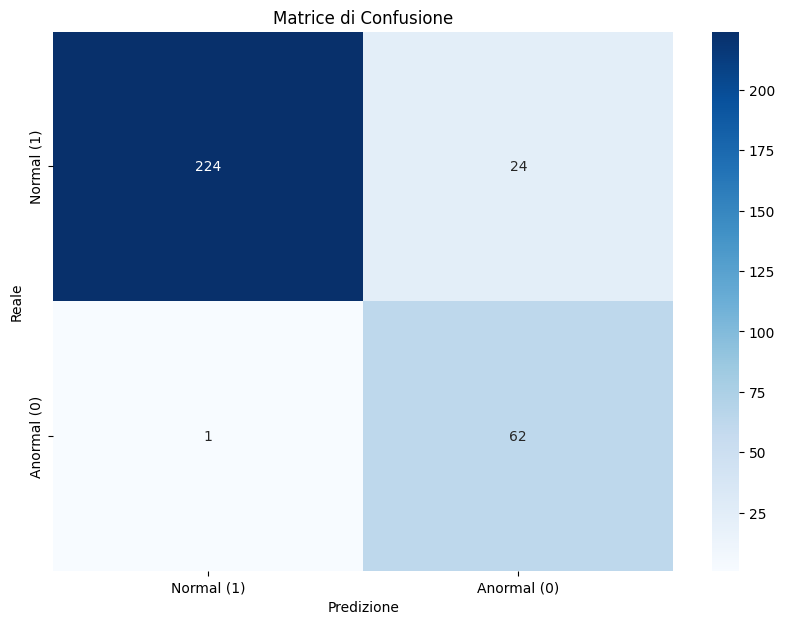

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as K
import seaborn as sns

class AnomalyDetectionModel:

    def contrastive_loss(y_true, y_pred):
        margin = 1
        y_true = K.cast(y_true, dtype='float32')
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean((1 - y_true) * square_pred + y_true * margin_square)

    def __init__(self):

        self.threshold = 0.45
        # Load autoencoder models
        self.autoencoderN = load_model('./models/autoencoder_normal1.h5')
        self.siamese_model = load_model('./models/best_siamese_model.h5', custom_objects={'contrastive_loss': self.contrastive_loss})

    def predict(self, sample_traffic):
        # Ensure sample_traffic has the expected shape
        sample_traffic = sample_traffic.reshape(1, -1)

        # Get latent representations using autoencoders
        latent_representation_normal = self.autoencoderN.predict(sample_traffic)

        # Build input data for the Siamese model
        siamese_input_normal = [sample_traffic, latent_representation_normal]

        # Evaluate the Siamese model to get Euclidean distances
        score_normal = self.siamese_model.predict(siamese_input_normal)[0]

        # Print the scores
        print(f'Score for Normal: {score_normal}')

        # Make prediction based on the threshold
        if score_normal > self.threshold:
            print("Predict: 1 (Normal)")
            return 1  # Normal
        else:
            print("Predict: 0 (Anomalous)")
            return 0  # Anomalous

def evaluate_anomaly_detection_model(model, x_subset, y_subset):
    predictions = []
    true_labels = []
    num = 1  # Azzeramento del numero di chiamata

    for sample_traffic, true_label in zip(x_subset, y_subset):
        print(30*"-")
        classification = model.predict(sample_traffic)
        print("Chiamata numero:", num)  # Stampa il numero della chiamata
        print("Expected Label:", true_label)
        predictions.append(classification)
        true_labels.append(true_label)
        print(30*"-")

        # Incrementa il numero della chiamata per la prossima iterazione
        num += 1

    # Calcolo delle metriche per il subset corrente
    confusion_mat = confusion_matrix(true_labels, predictions)
    print(confusion_mat)

    return confusion_mat


def getResult(t, cm, N_CLASSES):
    tp = cm[0][0]
    fn = cm[1][0]
    fp = cm[0][1]
    tn = cm[1][1]
    attacks = fp + tn  # Totali normali predetti come attacchi
    normals = tp + fn
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / normals) + (tn / attacks)) / N_CLASSES
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [t, tp, fn, fp, tn, OA, AA, P, R, F1, FAR, TPR]
    return r


# Create an instance of the AnomalyDetectionModel
anomaly_detection_model = AnomalyDetectionModel()

# Lists to save average metrics over runs
average_accuracy = []
average_precision = []
average_recall = []
average_f1 = []
average_confusion_matrix = np.zeros((2, 2), dtype=int)

from IPython.display import clear_output

runs = 10
index = 1

for index in range(runs):
    clear_output(wait=True)
    print(20*"-", "Range : ", index , 20*"-")
    # Azzeramento per la nuova esecuzione
    _, x_subset, _, y_subset = train_test_split(test_X, test_Y, test_size=0.001, random_state=None)
    print("SHAPE: ", x_subset.shape)

    # Valuta il modello per il subset corrente
    confusion_mat = evaluate_anomaly_detection_model(anomaly_detection_model, x_subset, y_subset)

    average_confusion_matrix += confusion_mat


average_confusion_matrix = average_confusion_matrix // runs  # Average the confusion matrix


# Print average confusion matrix
print("Average Confusion Matrix:")
print(average_confusion_matrix)


# Calcola i risultati utilizzando la funzione getResult
r = getResult('Esperimento2', average_confusion_matrix, 2)
columns = ['Method', 'TP', 'FN', 'FP', 'TN', 'OA', 'AA', 'Precision', 'Recall', 'F1', 'FAR', 'TPR']
results_df = pd.DataFrame([r], columns=columns)
print(results_df)

# Save average results to a file
filename = f"esperimento2_anomaly_detection_results-{runs}.txt"
with open(filename, "w") as file:
    results_df.to_csv(file, index=False, header=file.tell()==0)

print(f"Average results saved to '{filename}'")


import matplotlib.pyplot as plt

# Stampa la matrice di confusione media
plt.figure(figsize=(10, 7))
plt.title(f'Average Confusion Matrix over {runs} Runs')
# Etichette delle classi
class_labels = ["Normal (1)", "Anormal (0)"]

# Creazione della heatmap
sns.heatmap(average_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Aggiungi etichette e titolo
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')

# Mostra la heatmap
plt.show()




## Esperimento 3: Anomaly Detection System
- Un autoencoder Anormal
- Una rete siamese

Il traffico X passa attraverso l'autoencoder Anormal il quale ricostruisce X', si crea la coppia (X, x'). La coppie (X,X') va in input alla rete siamese che genera un punteggio di similarità S_A (riferimento alla rappresentazione Anormal). Se S_A > soglia (fissata a 0,45) il traffico è Anormal (Classe 0) altrimenti 1.

-------------------- Range :  9 --------------------
SHAPE:  (312, 119)
------------------------------
1/1 [==============================] - 0s 52ms/step
Score for Anomalous: [0.90320396]
Predict: 0 (Anomalous)
Chiamata numero: 1
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 54ms/step
Score for Anomalous: [0.90320396]
Predict: 0 (Anomalous)
Chiamata numero: 2
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 68ms/step
Score for Anomalous: [0.90320396]
Predict: 0 (Anomalous)
Chiamata numero: 3
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 58ms/step
Score for Anomalous: [0.90320396]
Predict: 0 (Anomalous)
Chiamata numero: 4
Expected Label: 0
------------------------------
------------------------------
1/1 [==============================] - 0s 33ms/step
Score for Ano

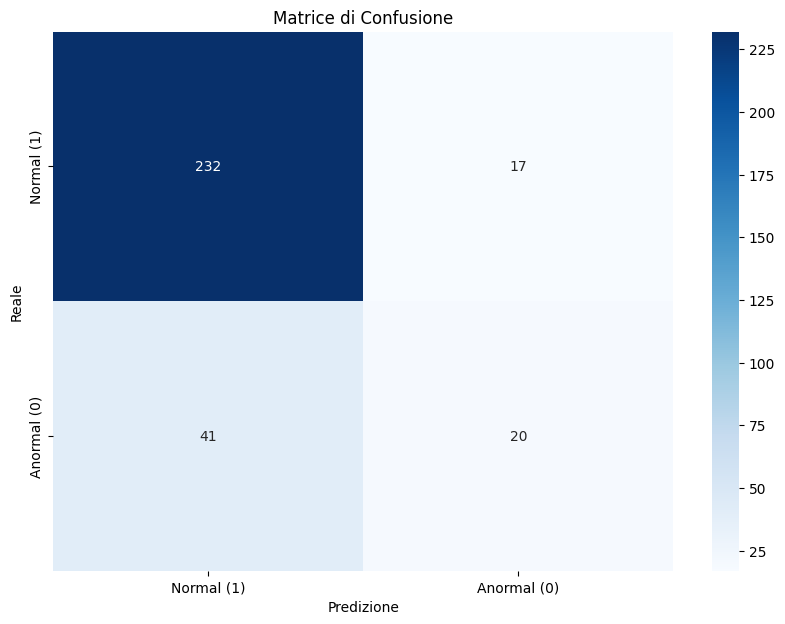

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as K
import seaborn as sns

class AnomalyDetectionModel:

    def contrastive_loss(y_true, y_pred):
        margin = 1
        y_true = K.cast(y_true, dtype='float32')
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean((1 - y_true) * square_pred + y_true * margin_square)

    def __init__(self):

        # Load autoencoder models
        self.threshold = 0.45
        self.autoencoderA = load_model('./models/autoencoder_anormal1.h5')
        self.siamese_model = load_model('./models/best_siamese_model.h5', custom_objects={'contrastive_loss': self.contrastive_loss})

    def predict(self, sample_traffic):
        # Ensure sample_traffic has the expected shape
        sample_traffic = sample_traffic.reshape(1, -1)

        # Get latent representations using autoencoders
        latent_representation_anomalous = self.autoencoderA.predict(sample_traffic)

        # Build input data for the Siamese model
        siamese_input_anomalous = [sample_traffic, latent_representation_anomalous]

        # Evaluate the Siamese model to get Euclidean distances
        score_anomalous = self.siamese_model.predict(siamese_input_anomalous)[0]

        # Print the scores
        print(f'Score for Anomalous: {score_anomalous}')

        # Make prediction based on the threshold
        if score_anomalous > self.threshold:
            print("Predict: 0 (Anomalous)")
            return 0  # Anormal
        else:
            print("Predict: 1 (Normal)")
            return 1  # Normal

def evaluate_anomaly_detection_model(model, x_subset, y_subset):
    predictions = []
    true_labels = []
    num = 1  # Azzeramento del numero di chiamata

    for sample_traffic, true_label in zip(x_subset, y_subset):
        print(30*"-")
        classification = model.predict(sample_traffic)
        print("Chiamata numero:", num)  # Stampa il numero della chiamata
        print("Expected Label:", true_label)
        predictions.append(classification)
        true_labels.append(true_label)
        print(30*"-")

        # Incrementa il numero della chiamata per la prossima iterazione
        num += 1

    # Calcolo delle metriche per il subset corrente
    confusion_mat = confusion_matrix(true_labels, predictions)
    print(confusion_mat)

    return confusion_mat


def getResult(t, cm, N_CLASSES):
    tp = cm[0][0]
    fn = cm[1][0]
    fp = cm[0][1]
    tn = cm[1][1]
    attacks = fp + tn  # Totali normali predetti come attacchi
    normals = tp + fn
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / normals) + (tn / attacks)) / N_CLASSES
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [t, tp, fn, fp, tn, OA, AA, P, R, F1, FAR, TPR]
    return r


# Create an instance of the AnomalyDetectionModel
anomaly_detection_model = AnomalyDetectionModel()

# Lists to save average metrics over runs
average_confusion_matrix = np.zeros((2, 2), dtype=int)

from IPython.display import clear_output

runs = 10
index = 1

for index in range(runs):
    clear_output(wait=True)
    print(20*"-", "Range : ", index , 20*"-")
    # Azzeramento per la nuova esecuzione
    _, x_subset, _, y_subset = train_test_split(test_X, test_Y, test_size=0.001, random_state=None)
    print("SHAPE: ", x_subset.shape)

    # Valuta il modello per il subset corrente
    confusion_mat = evaluate_anomaly_detection_model(anomaly_detection_model, x_subset, y_subset)
    average_confusion_matrix += confusion_mat


# Calculate average metrics over runs
average_confusion_matrix = average_confusion_matrix // runs  # Average the confusion matrix


print("Average Confusion Matrix:")
print(average_confusion_matrix)

# Calcola i risultati utilizzando la funzione getResult
r = getResult('Esperimento3', average_confusion_matrix, 2)
columns = ['Method', 'TP', 'FN', 'FP', 'TN', 'OA', 'AA', 'Precision', 'Recall', 'F1', 'FAR', 'TPR']
results_df = pd.DataFrame([r], columns=columns)
print(results_df)


# Salva i risultati in un file
filename = f"esperimento3_anomaly_detection_results-{runs}.txt"
with open(filename, "a") as file:
    results_df.to_csv(file, index=False, header=file.tell()==0)

print(f"Average results saved to '{filename}'")

plt.figure(figsize=(10, 7))
plt.title(f'Average Confusion Matrix over {runs} Runs')
# Etichette delle classi
class_labels = ["Normal (1)", "Anormal (0)"]

# Creazione della heatmap
sns.heatmap(average_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Aggiungi etichette e titolo
plt.xlabel('Predizione')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')

# Mostra la heatmap
plt.show()

